In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm


# Enable 64-bit precision in JAX
jax.config.update("jax_enable_x64", True)

# Domain size and DHIT parameters
nx, ny, nz = 64, 64, 64
u0 = 0.1  # Initial velocity amplitude
KINEMATIC_VISCOSITY = 0.009  # Try a smaller viscosity for faster dissipation
RELAXATION_OMEGA = 1.0 / (3.0 * KINEMATIC_VISCOSITY + 0.5)

PLOT_EVERY_N_STEPS = 50
N_ITERATIONS = 500

# Define the number of discrete velocities for D3Q19
N_DISCRETE_VELOCITIES = 19

# Lattice indices and velocities for D3Q19 model
LATTICE_INDICES = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
LATICE_VELOCITIES_X = jnp.array([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, 1, -1, 0, 0, 0, 0])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, -1, -1, 1])
OPPOSITE_LATTICE_INDICES = jnp.array([0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15, 18, 17])

LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X, LATICE_VELOCITIES_Y, LATICE_VELOCITIES_Z])
LATTICE_WEIGHTS = jnp.array([
    1/3,     # rest particle
    
    # face-connected neighbors
    1/18, 1/18, 1/18, 1/18, 1/18, 1/18,
    
    # edge-connected neighbors
    1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36
])

# Define functions
def get_density(discrete_velocities):
    return jnp.sum(discrete_velocities, axis=-1)

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("NMLQ,dQ->NMLd", discrete_velocities, LATTICE_VELOCITIES) / density[..., jnp.newaxis]

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,NMLd->NMLQ", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1, ord=2)
    equilibrium_discrete_velocities = (
        density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities +
         9/2 * projected_discrete_velocities**2 -
         3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2)
    )
    return equilibrium_discrete_velocities

# Generate initial velocity and density fields with DHIT/TGV conditions
x = jnp.arange(1, nx+1) / nx
y = jnp.arange(1, ny+1) / ny
z = jnp.arange(1, nz+1) / nz
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
uy = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
uz = jnp.zeros_like(ux)
rho = 1.0 + (u0**2 / 16.0) * (jnp.cos(4.0 * jnp.pi * X) + jnp.cos(4.0 * jnp.pi * Y)) * (jnp.cos(4.0 * jnp.pi * Z) + 2.0)

#OR TGV

# ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Z)  # TGV X-velocity component
# uy = jnp.zeros_like(ux)                                       # TGV Y-velocity component
# uz = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Z)  # TGV Z-velocity component
# rho = jnp.ones_like(ux)                                       # Uniform density

# Combine initial velocity into the velocity field
VELOCITY_PROFILE = jnp.stack((ux, uy, uz), axis=-1)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE, rho)

# Collision and Streaming update with corrections
@jax.jit
def update(discrete_velocities_prev):
    # Calculate density and macroscopic velocities
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(discrete_velocities_prev, density_prev)
    
    # Compute discrete equilibrium velocities
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(macroscopic_velocities_prev, density_prev)
    
    # Collision step using BGK model
    discrete_velocities_post_collision = (
        discrete_velocities_prev - RELAXATION_OMEGA * (discrete_velocities_prev - equilibrium_discrete_velocities)
    )
    
    # Streaming step with periodic boundary conditions
    discrete_velocities_streamed = discrete_velocities_post_collision
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(
                jnp.roll(
                    jnp.roll(discrete_velocities_post_collision[..., i],
                             LATTICE_VELOCITIES[i, 0], axis=0),
                    LATTICE_VELOCITIES[i, 1], axis=1),
                LATTICE_VELOCITIES[i, 2], axis=2)
        )
    
    return discrete_velocities_streamed

# Function to calculate total kinetic energy
def calculate_kinetic_energy(macroscopic_velocities):
    return 0.5 * jnp.sum(jnp.square(macroscopic_velocities))

# Updated run function to track kinetic energy
def run(discrete_velocities_prev):   
    kinetic_energy_over_time = []
    for i in tqdm(range(N_ITERATIONS)):
        discrete_velocities_next = update(discrete_velocities_prev)
        discrete_velocities_prev = discrete_velocities_next
        
        # Calculate kinetic energy
        density = get_density(discrete_velocities_next)
        macroscopic_velocities = get_macroscopic_velocities(discrete_velocities_next, density)
        kinetic_energy = calculate_kinetic_energy(macroscopic_velocities)
        kinetic_energy_over_time.append(kinetic_energy)
        
        # Plot every PLOT_EVERY_N_STEPS
        if i % PLOT_EVERY_N_STEPS == 0:
            plt.figure(figsize=(6, 6))
            plt.contourf(X[:, :, nx//2], Y[:, :, nx//2], jnp.linalg.norm(macroscopic_velocities[:, :, nx//2], axis=-1), cmap='inferno')
            plt.colorbar(label="Velocity Magnitude")
            plt.title(f"Iteration {i}")
            plt.axis("scaled")
            plt.show()

    # Plot kinetic energy decay over time
    plt.figure()
    plt.plot(kinetic_energy_over_time)
    plt.xlabel("Iteration")
    plt.ylabel("Total Kinetic Energy")
    plt.title("Energy Decay over Time")
    plt.show()

run(discrete_velocities_prev)


Corrected DHIT

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)

nx, ny, nz = 64, 64, 64
u0 = 0.1
KINEMATIC_VISCOSITY = 0.009
RELAXATION_OMEGA = 1.0 / (3.0 * KINEMATIC_VISCOSITY + 0.5)

PLOT_EVERY_N_STEPS = 100
N_ITERATIONS = 1000

N_DISCRETE_VELOCITIES = 19
LATICE_VELOCITIES_X = jnp.array([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, 1, -1, 0, 0, 0, 0])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, -1, -1, 1])
LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X, LATICE_VELOCITIES_Y, LATICE_VELOCITIES_Z])
LATTICE_WEIGHTS = jnp.array([
    1/3, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18,
    1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36
])

def get_density(discrete_velocities):
    return jnp.sum(discrete_velocities, axis=-1)

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("dQ,ijkQ->ijkd", LATTICE_VELOCITIES, discrete_velocities) / density[..., jnp.newaxis]

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,ijkd->ijkQ", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1)
    equilibrium_discrete_velocities = (
        density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities +
         9/2 * projected_discrete_velocities**2 -
         3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2)
    )
    return equilibrium_discrete_velocities

x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
z = jnp.linspace(0, 1, nz)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
uy = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
uz = jnp.zeros_like(ux)
rho = 1.0 + (u0**2 / 16.0) * (jnp.cos(4.0 * jnp.pi * X) + jnp.cos(4.0 * jnp.pi * Y)) * (jnp.cos(4.0 * jnp.pi * Z) + 2.0)

VELOCITY_PROFILE = jnp.stack((ux, uy, uz), axis=-1)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE, rho)

@jax.jit
def update(discrete_velocities_prev):
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(discrete_velocities_prev, density_prev)
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(macroscopic_velocities_prev, density_prev)

    discrete_velocities_post_collision = (
        discrete_velocities_prev - RELAXATION_OMEGA * (discrete_velocities_prev - equilibrium_discrete_velocities)
    )

    discrete_velocities_streamed = jnp.zeros_like(discrete_velocities_post_collision)
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(
                jnp.roll(
                    jnp.roll(discrete_velocities_post_collision[..., i],
                             shift=LATTICE_VELOCITIES[0, i], axis=0),
                    shift=LATTICE_VELOCITIES[1, i], axis=1),
                shift=LATTICE_VELOCITIES[2, i], axis=2)
        )

    return discrete_velocities_streamed

def calculate_kinetic_energy(macroscopic_velocities):
    return 0.5 * jnp.sum(jnp.square(macroscopic_velocities))

def run(discrete_velocities_prev):
    kinetic_energy_over_time = []
    for i in tqdm(range(N_ITERATIONS)):
        discrete_velocities_next = update(discrete_velocities_prev)
        discrete_velocities_prev = discrete_velocities_next
        
        density = get_density(discrete_velocities_next)
        macroscopic_velocities = get_macroscopic_velocities(discrete_velocities_next, density)
        kinetic_energy = calculate_kinetic_energy(macroscopic_velocities)
        kinetic_energy_over_time.append(kinetic_energy)
        
        if i % PLOT_EVERY_N_STEPS == 0:
            plt.figure(figsize=(5, 5))
            plt.contourf(X[:, :, nx//2], Y[:, :, nx//2], jnp.linalg.norm(macroscopic_velocities[:, :, nx//2], axis=-1), cmap='inferno')
            plt.colorbar(label="Velocity Magnitude")
            plt.title(f"Iteration {i}")
            plt.axis("scaled")
            plt.show()

    plt.figure()
    plt.plot(kinetic_energy_over_time)
    plt.xlabel("Iteration")
    plt.ylabel("Total Kinetic Energy")
    plt.title("Energy Decay over Time")
    plt.show()

run(discrete_velocities_prev)

Save data section added, save data in separate files

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)

nx, ny, nz = 64, 64, 64
u0 = 0.1
KINEMATIC_VISCOSITY = 0.009
RELAXATION_OMEGA = 1.0 / (3.0 * KINEMATIC_VISCOSITY + 0.5)

PLOT_EVERY_N_STEPS = 10
SAVE_EVERY_N_STEPS = 100
N_ITERATIONS = 100

N_DISCRETE_VELOCITIES = 19
LATICE_VELOCITIES_X = jnp.array([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, 1, -1, 0, 0, 0, 0])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, -1, -1, 1])
LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X, LATICE_VELOCITIES_Y, LATICE_VELOCITIES_Z])
LATTICE_WEIGHTS = jnp.array([
    1/3, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18,
    1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36
])

def get_density(discrete_velocities):
    return jnp.sum(discrete_velocities, axis=-1)

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("dQ,ijkQ->ijkd", LATTICE_VELOCITIES, discrete_velocities) / density[..., jnp.newaxis]

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,ijkd->ijkQ", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1)
    equilibrium_discrete_velocities = (
        density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities +
         9/2 * projected_discrete_velocities**2 -
         3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2)
    )
    return equilibrium_discrete_velocities

x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
z = jnp.linspace(0, 1, nz)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
uy = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
uz = jnp.zeros_like(ux)
rho = 1.0 + (u0**2 / 16.0) * (jnp.cos(4.0 * jnp.pi * X) + jnp.cos(4.0 * jnp.pi * Y)) * (jnp.cos(4.0 * jnp.pi * Z) + 2.0)

VELOCITY_PROFILE = jnp.stack((ux, uy, uz), axis=-1)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE, rho)

@jax.jit
def update(discrete_velocities_prev):
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(discrete_velocities_prev, density_prev)
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(macroscopic_velocities_prev, density_prev)

    discrete_velocities_post_collision = (
        discrete_velocities_prev - RELAXATION_OMEGA * (discrete_velocities_prev - equilibrium_discrete_velocities)
    )

    discrete_velocities_streamed = jnp.zeros_like(discrete_velocities_post_collision)
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(
                jnp.roll(
                    jnp.roll(discrete_velocities_post_collision[..., i],
                             shift=LATTICE_VELOCITIES[0, i], axis=0),
                    shift=LATTICE_VELOCITIES[1, i], axis=1),
                shift=LATTICE_VELOCITIES[2, i], axis=2)
        )

    return discrete_velocities_streamed

def calculate_kinetic_energy(macroscopic_velocities):
    return 0.5 * jnp.sum(jnp.square(macroscopic_velocities))

def run(discrete_velocities_prev):
    kinetic_energy_over_time = []
    for i in tqdm(range(N_ITERATIONS)):
        discrete_velocities_next = update(discrete_velocities_prev)
        discrete_velocities_prev = discrete_velocities_next
        
        density = get_density(discrete_velocities_next)
        macroscopic_velocities = get_macroscopic_velocities(discrete_velocities_next, density)
        kinetic_energy = calculate_kinetic_energy(macroscopic_velocities)
        kinetic_energy_over_time.append(kinetic_energy)
        
        if i % PLOT_EVERY_N_STEPS == 0:
            plt.figure(figsize=(6, 6))
            plt.contourf(X[:, :, nx//2], Y[:, :, nx//2], jnp.linalg.norm(macroscopic_velocities[:, :, nx//2], axis=-1), cmap='inferno')
            plt.colorbar(label="Velocity Magnitude")
            plt.title(f"Iteration {i}")
            plt.axis("scaled")
            plt.show()
        
        if i % SAVE_EVERY_N_STEPS == 0:
            with open(f"velocity_data_{i}.dat", "w") as f:
                f.write(f"Iteration: {i}\n")
                f.write("Velocity Data (ux uy uz):\n")
                for ix in range(nx):
                    for iy in range(ny):
                        for iz in range(nz):
                            f.write(f"{macroscopic_velocities[ix, iy, iz, 0]} {macroscopic_velocities[ix, iy, iz, 1]} {macroscopic_velocities[ix, iy, iz, 2]}\n")

    plt.figure()
    plt.plot(kinetic_energy_over_time)
    plt.xlabel("Iteration")
    plt.ylabel("Total Kinetic Energy")
    plt.title("Energy Decay over Time")
    plt.show()

run(discrete_velocities_prev)

Save data in a single file

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)

nx, ny, nz = 64, 64, 64
u0 = 0.1
KINEMATIC_VISCOSITY = 0.01
RELAXATION_OMEGA = 1.0 / (3.0 * KINEMATIC_VISCOSITY + 0.5)

PLOT_EVERY_N_STEPS = 10
SAVE_EVERY_N_STEPS = 100
N_ITERATIONS = 50

N_DISCRETE_VELOCITIES = 19
LATICE_VELOCITIES_X = jnp.array([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, 1, -1, 0, 0, 0, 0])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, -1, -1, 1])
LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X, LATICE_VELOCITIES_Y, LATICE_VELOCITIES_Z])
LATTICE_WEIGHTS = jnp.array([
    1/3, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18,
    1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36
])

def get_density(discrete_velocities):
    return jnp.sum(discrete_velocities, axis=-1)

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("dQ,ijkQ->ijkd", LATTICE_VELOCITIES, discrete_velocities) / density[..., jnp.newaxis]

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,ijkd->ijkQ", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1)
    equilibrium_discrete_velocities = (
        density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities +
         9/2 * projected_discrete_velocities**2 -
         3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2)
    )
    return equilibrium_discrete_velocities

# Initialize grid
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
z = jnp.linspace(0, 1, nz)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

# OR same as fortran 

# x = (jnp.linspace(0, 1, nx) - 0.5) / 1.0  # Center and normalize by grid size
# y = (jnp.linspace(0, 1, ny) - 0.5) / 1.0
# z = (jnp.linspace(0, 1, nz) - 0.5) / 1.0
# X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

# ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
# uy = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
# uz = jnp.zeros_like(ux)
# rho = 1.0 + (u0**2 / 16.0) * (jnp.cos(4.0 * jnp.pi * X) + jnp.cos(4.0 * jnp.pi * Y)) * (jnp.cos(4.0 * jnp.pi * Z) + 2.0)

#OR TGV

ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Z)  # TGV X-velocity component
uy = jnp.zeros_like(ux)                                       # TGV Y-velocity component
uz = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Z)  # TGV Z-velocity component
rho = jnp.ones_like(ux)  

VELOCITY_PROFILE = jnp.stack((ux, uy, uz), axis=-1)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE, rho)

@jax.jit
def update(discrete_velocities_prev):
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(discrete_velocities_prev, density_prev)
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(macroscopic_velocities_prev, density_prev)

    discrete_velocities_post_collision = (
        discrete_velocities_prev - RELAXATION_OMEGA * (discrete_velocities_prev - equilibrium_discrete_velocities)
    )

    discrete_velocities_streamed = jnp.zeros_like(discrete_velocities_post_collision)
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(
                jnp.roll(
                    jnp.roll(discrete_velocities_post_collision[..., i],
                             shift=LATTICE_VELOCITIES[0, i], axis=0),
                    shift=LATTICE_VELOCITIES[1, i], axis=1),
                shift=LATTICE_VELOCITIES[2, i], axis=2)
        )

    return discrete_velocities_streamed

def calculate_kinetic_energy(macroscopic_velocities):
    return 0.5 * jnp.sum(jnp.square(macroscopic_velocities))

def run(discrete_velocities_prev):
    kinetic_energy_over_time = []

    grid_size = nx * ny * nz  # Total number of grid points (for normalization)
    
    # with open("velocity_data.dat", "w") as f:
    with open("ke_data.dat", "a") as ke_file:
        for i in tqdm(range(N_ITERATIONS)):
            discrete_velocities_next = update(discrete_velocities_prev)
            discrete_velocities_prev = discrete_velocities_next
            
            density = get_density(discrete_velocities_next)
            macroscopic_velocities = get_macroscopic_velocities(discrete_velocities_next, density)
            kinetic_energy = calculate_kinetic_energy(macroscopic_velocities)
            
            kinetic_energy_over_time.append(kinetic_energy)
            
            if i % PLOT_EVERY_N_STEPS == 0:
                plt.figure(figsize=(4, 4))
                plt.contourf(X[:, :, nx//2], Y[:, :, nx//2], jnp.linalg.norm(macroscopic_velocities[:, :, nx//2], axis=-1), cmap='inferno')
                plt.colorbar(label="Velocity Magnitude")
                plt.title(f"Iteration {i}")
                plt.axis("scaled")
                plt.show()

            # Or normalized plot

            # if i % PLOT_EVERY_N_STEPS == 0:
            #     plt.figure(figsize=(4, 4))
            #     # Normalize the velocity magnitude by the grid size
            #     normalized_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities[:, :, nx // 2], axis=-1) / (nx * ny * nz)
            #     plt.contourf(X[:, :, nx // 2], Y[:, :, nx // 2], normalized_velocity_magnitude, cmap='inferno')
            #     plt.colorbar(label="Normalized Velocity Magnitude")
            #     plt.title(f"Iteration {i}")
            #     plt.axis("scaled")
            #     plt.show()
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                
            # if i % SAVE_EVERY_N_STEPS == 0:
            #     print(f"Saving data at iteration {i}...") 
            #     for ix in range(nx):
            #         for iy in range(ny):
            #             for iz in range(nz):
            #                 f.write(f"{i} {macroscopic_velocities[ix, iy, iz, 0]:.10f} "
            #                         f"{macroscopic_velocities[ix, iy, iz, 1]:.10f} "
            #                         f"{macroscopic_velocities[ix, iy, iz, 2]:.10f}\n")
            #     f.flush()  # Ensure data is written to disk

            # OR !!!!!!!!!!

            # if i % SAVE_EVERY_N_STEPS == 0:
            #     print(f"Saving data at iteration {i}...") 
            #     for ix in range(nx):
            #         for iy in range(ny):
            #             for iz in range(nz):
            #                 # Normalize the velocity components by the grid size
            #                 normalized_vx = macroscopic_velocities[ix, iy, iz, 0] / grid_size
            #                 normalized_vy = macroscopic_velocities[ix, iy, iz, 1] / grid_size
            #                 normalized_vz = macroscopic_velocities[ix, iy, iz, 2] / grid_size
                            
            #                 f.write(f"{i} {normalized_vx:.10f} {normalized_vy:.10f} {normalized_vz:.10f}\n")
            #     f.flush()  # Ensure data is written to disk    
            # 
            # Save kinetic energy data only at intervals of SAVE_EVERY_N_STEPS
            if i % SAVE_EVERY_N_STEPS == 0:
                print(f"Saving data at iteration {i}...")
                # Normalize the kinetic energy by the grid size
                normalized_kinetic_energy = kinetic_energy / grid_size
                # Write only the current iteration and normalized kinetic energy
                ke_file.write(f"{i:10d} {normalized_kinetic_energy:.6e}\n")
                ke_file.flush()  # Ensure data is written to the file
            
    # plt.figure()
    # plt.plot(kinetic_energy_over_time)
    # plt.xlabel("Iteration")
    # plt.ylabel("Total Kinetic Energy")
    # plt.title("Energy Decay over Time")
    # plt.show()

    # OR
    plt.figure()
    # Normalize the kinetic energy by the grid size
    normalized_kinetic_energy = [ke / (nx * ny * nz) for ke in kinetic_energy_over_time]
    plt.plot(normalized_kinetic_energy)
    plt.xlabel("Iteration")
    plt.ylabel("Normalized Total Kinetic Energy")
    plt.title("Energy Decay over Time (Normalized)")
    plt.show()


run(discrete_velocities_prev)

For GIT

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)

# Choose Flow Type: Set to 'DHIT' for DHIT flow or 'TGV' for TGV flow
FLOW_TYPE = 'DHIT'  # DHIT => Decay Homogeneous Isotropic Turbulence
                    # TGV => Taylor-Green vortex

# Grid dimensions
nx, ny, nz = 64, 64, 64
u0 = 0.1
KINEMATIC_VISCOSITY = 0.01
RELAXATION_OMEGA = 1.0 / (3.0 * KINEMATIC_VISCOSITY + 0.5)

PLOT_EVERY_N_STEPS = 50
SAVE_EVERY_N_STEPS = 10
N_ITERATIONS = 100

N_DISCRETE_VELOCITIES = 19
LATICE_VELOCITIES_X = jnp.array([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, 1, -1, 0, 0, 0, 0])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, -1, -1, 1])
LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X, LATICE_VELOCITIES_Y, LATICE_VELOCITIES_Z])

LATTICE_WEIGHTS = jnp.array([# Zero weight
                             1/3,


                            # Adjacent weights
                            1/18, 1/18, 1/18, 1/18, 1/18, 1/18,


                            # Diagonal weights
                            1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36])

# Initialize grid

x = (jnp.linspace(0, 1, nx) - 0.5) / 1.0  # Center and normalize by grid size
y = (jnp.linspace(0, 1, ny) - 0.5) / 1.0
z = (jnp.linspace(0, 1, nz) - 0.5) / 1.0

X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")


# Velocity profile based on the selected flow type
if FLOW_TYPE == 'DHIT':
    # DHIT flow
    ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
    uy = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
    uz = jnp.zeros_like(ux)
    rho = 1.0 + (u0**2 / 16.0) * (jnp.cos(4.0 * jnp.pi * X) + jnp.cos(4.0 * jnp.pi * Y)) * (jnp.cos(4.0 * jnp.pi * Z) + 2.0)
elif FLOW_TYPE == 'TGV':
    # TGV 2D flow
    ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Z)  # TGV X-velocity component
    uy = jnp.zeros_like(ux)                                       # TGV Y-velocity component
    uz = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Z)  # TGV Z-velocity component
    rho = jnp.ones_like(ux)  
else:
    raise ValueError("FLOW_TYPE must be either 'DHIT' or 'TGV'.")

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,ijkd->ijkQ", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1)
    equilibrium_discrete_velocities = (
        density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities +
         9/2 * projected_discrete_velocities**2 - 
         3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2)
    )
    return equilibrium_discrete_velocities

# Stack the velocity components
VELOCITY_PROFILE = jnp.stack((ux, uy, uz), axis=-1)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE, rho)

# Function Definitions
def get_density(discrete_velocities):
    return jnp.sum(discrete_velocities, axis=-1)

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("dQ,ijkQ->ijkd", LATTICE_VELOCITIES, discrete_velocities) / density[..., jnp.newaxis]


@jax.jit
def update(discrete_velocities_prev):
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(discrete_velocities_prev, density_prev)
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(macroscopic_velocities_prev, density_prev)

    discrete_velocities_post_collision = (
        discrete_velocities_prev - RELAXATION_OMEGA * (discrete_velocities_prev - equilibrium_discrete_velocities)
    )

    discrete_velocities_streamed = jnp.zeros_like(discrete_velocities_post_collision)
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(
                jnp.roll(
                    jnp.roll(discrete_velocities_post_collision[..., i],
                             shift=LATTICE_VELOCITIES[0, i], axis=0),
                    shift=LATTICE_VELOCITIES[1, i], axis=1),
                shift=LATTICE_VELOCITIES[2, i], axis=2)
        )

    return discrete_velocities_streamed

def calculate_kinetic_energy(macroscopic_velocities):
    return 0.5 * jnp.sum(jnp.square(macroscopic_velocities))

def run(discrete_velocities_prev):
    kinetic_energy_over_time = []

    grid_size = nx * ny * nz  # Total number of grid points (for normalization)

    with open("ke_data.dat", "a") as ke_file:
        for i in tqdm(range(N_ITERATIONS)):
            discrete_velocities_next = update(discrete_velocities_prev)
            discrete_velocities_prev = discrete_velocities_next
            
            density = get_density(discrete_velocities_next)
            macroscopic_velocities = get_macroscopic_velocities(discrete_velocities_next, density)
            kinetic_energy = calculate_kinetic_energy(macroscopic_velocities)
            
            kinetic_energy_over_time.append(kinetic_energy)

            if i % PLOT_EVERY_N_STEPS == 0:
                plt.figure(figsize=(4, 4))
                # Normalize the velocity magnitude by the grid size
                normalized_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities[:, :, nx // 2], axis=-1) / (nx * ny * nz)
                plt.contourf(X[:, :, nx // 2], Y[:, :, nx // 2], normalized_velocity_magnitude, cmap='inferno')
                plt.colorbar(label="Normalized Velocity Magnitude")
                plt.title(f"Iteration {i}")
                plt.axis("scaled")
                plt.show()

            # Save kinetic energy data only at intervals of SAVE_EVERY_N_STEPS
            if i % SAVE_EVERY_N_STEPS == 0:
                print(f"Saving data at iteration {i}...")
                # Normalize the kinetic energy by the grid size
                normalized_kinetic_energy = kinetic_energy / grid_size
                # Write only the current iteration and normalized kinetic energy
                ke_file.write(f"{i:10d} {normalized_kinetic_energy:.6e}\n")
                ke_file.flush()  # Ensure data is written to the file

    plt.figure()
    # Normalize the kinetic energy by the grid size
    normalized_kinetic_energy = [ke / (nx * ny * nz) for ke in kinetic_energy_over_time]
    plt.plot(normalized_kinetic_energy)
    plt.xlabel("Iteration")
    plt.ylabel("Normalized Total Kinetic Energy")
    plt.title("Energy Decay over Time (Normalized)")
    plt.show()


# Run the simulation
run(discrete_velocities_prev)


Dissipation rate added

  0%|          | 0/2000 [00:00<?, ?it/s]

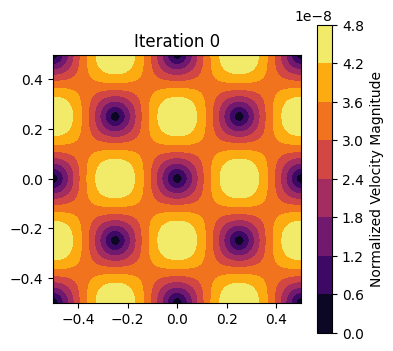

100%|██████████| 2000/2000 [47:44<00:00,  1.43s/it]


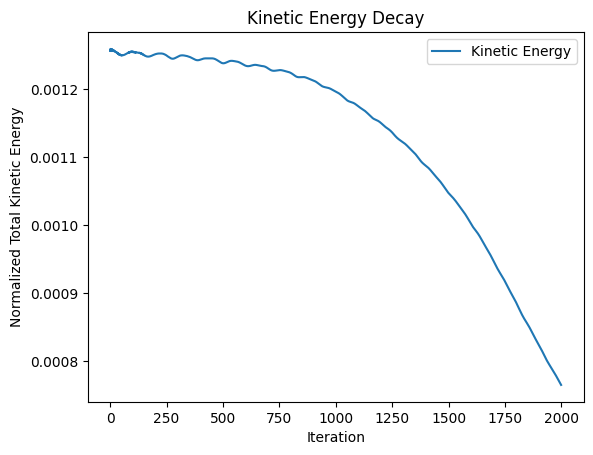

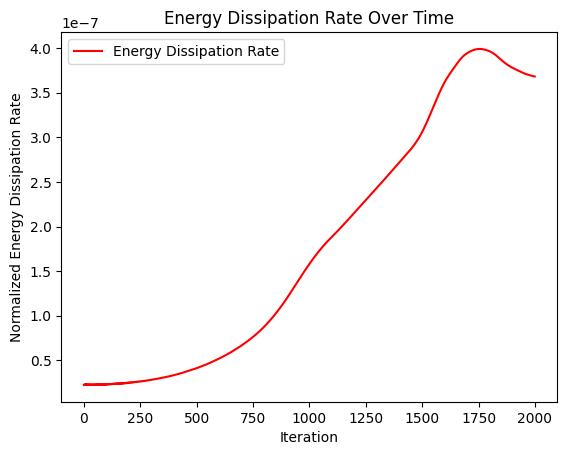

In [11]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)

# Choose Flow Type: Set to 'DHIT' for DHIT flow or 'TGV' for TGV flow
FLOW_TYPE = 'DHIT'  # DHIT => Decay Homogeneous Isotropic Turbulence
                    # TGV => Taylor-Green vortex

# Grid dimensions
nx, ny, nz = 128, 128, 128
u0 = 0.1
KINEMATIC_VISCOSITY = 0.00125
RELAXATION_OMEGA = 1.0 / (3.0 * KINEMATIC_VISCOSITY + 0.5)

PLOT_EVERY_N_STEPS = 5000
SAVE_EVERY_N_STEPS = 50000
N_ITERATIONS = 2000

N_DISCRETE_VELOCITIES = 19
LATICE_VELOCITIES_X = jnp.array([0, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 0, 0, 1, -1, 1, -1])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, 1, -1, 0, 0, 0, 0])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1, 1, 1, -1, -1, 1])
LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X, LATICE_VELOCITIES_Y, LATICE_VELOCITIES_Z])

LATTICE_WEIGHTS = jnp.array([
    1/3,  # Zero weight
    1/18, 1/18, 1/18, 1/18, 1/18, 1/18,  # Adjacent weights
    1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36  # Diagonal weights
])

# Initialize grid
x = (jnp.linspace(0, 1, nx) - 0.5) / 1.0  # Center and normalize by grid size
y = (jnp.linspace(0, 1, ny) - 0.5) / 1.0
z = (jnp.linspace(0, 1, nz) - 0.5) / 1.0

X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

# Velocity profile based on the selected flow type
if FLOW_TYPE == 'DHIT':
    ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
    uy = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Y) * jnp.cos(2 * jnp.pi * Z)
    uz = jnp.zeros_like(ux)
    rho = 1.0 + (u0**2 / 16.0) * (jnp.cos(4.0 * jnp.pi * X) + jnp.cos(4.0 * jnp.pi * Y)) * (jnp.cos(4.0 * jnp.pi * Z) + 2.0)
elif FLOW_TYPE == 'TGV':
    ux = u0 * jnp.sin(2 * jnp.pi * X) * jnp.cos(2 * jnp.pi * Z)
    uy = jnp.zeros_like(ux)
    uz = -u0 * jnp.cos(2 * jnp.pi * X) * jnp.sin(2 * jnp.pi * Z)
    rho = jnp.ones_like(ux)
else:
    raise ValueError("FLOW_TYPE must be either 'DHIT' or 'TGV'.")

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,ijkd->ijkQ", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1)
    equilibrium_discrete_velocities = (
        density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities +
         9/2 * projected_discrete_velocities**2 - 
         3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2)
    )
    return equilibrium_discrete_velocities

VELOCITY_PROFILE = jnp.stack((ux, uy, uz), axis=-1)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE, rho)

def get_density(discrete_velocities):
    return jnp.sum(discrete_velocities, axis=-1)

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("dQ,ijkQ->ijkd", LATTICE_VELOCITIES, discrete_velocities) / density[..., jnp.newaxis]

@jax.jit
def update(discrete_velocities_prev):
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(discrete_velocities_prev, density_prev)
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(macroscopic_velocities_prev, density_prev)

    discrete_velocities_post_collision = (
        discrete_velocities_prev - RELAXATION_OMEGA * (discrete_velocities_prev - equilibrium_discrete_velocities)
    )

    discrete_velocities_streamed = jnp.zeros_like(discrete_velocities_post_collision)
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(
                jnp.roll(
                    jnp.roll(discrete_velocities_post_collision[..., i],
                             shift=LATTICE_VELOCITIES[0, i], axis=0),
                    shift=LATTICE_VELOCITIES[1, i], axis=1),
                shift=LATTICE_VELOCITIES[2, i], axis=2)
        )

    return discrete_velocities_streamed

def calculate_kinetic_energy(macroscopic_velocities):
    return 0.5 * jnp.sum(jnp.square(macroscopic_velocities))

def calculate_energy_dissipation_rate(macroscopic_velocities, kinematic_viscosity):
    """
    Calculate the energy dissipation rate using the formula:
    ε = ν * sum(∂u_i/∂x_j * ∂u_i/∂x_j)

    Args:
        macroscopic_velocities: Velocity field (shape: [nx, ny, nz, 3])
        kinematic_viscosity: Kinematic viscosity ν

    Returns:
        Energy dissipation rate ε
    """
    # Compute gradients for each velocity component
    gradients = [
        jnp.gradient(macroscopic_velocities[..., d], axis=(0, 1, 2))
        for d in range(3)
    ]  # List of tuples (one tuple per velocity component)

    # Extract and square the gradients
    squared_gradients = sum(
        jnp.square(grad) for component_gradients in gradients for grad in component_gradients
    )  # Sum of squared gradients across all components and directions

    # Integrate over the domain
    energy_dissipation_rate = kinematic_viscosity * jnp.sum(squared_gradients)
    return energy_dissipation_rate



def run(discrete_velocities_prev):
    kinetic_energy_over_time = []
    energy_dissipation_over_time = []

    with open("ke_data.dat", "a") as ke_file, open("epsilon_data.dat", "a") as eps_file:
        for i in tqdm(range(N_ITERATIONS)):
            discrete_velocities_next = update(discrete_velocities_prev)
            discrete_velocities_prev = discrete_velocities_next
            
            density = get_density(discrete_velocities_next)
            macroscopic_velocities = get_macroscopic_velocities(discrete_velocities_next, density)
            kinetic_energy = calculate_kinetic_energy(macroscopic_velocities)
            energy_dissipation_rate = calculate_energy_dissipation_rate(macroscopic_velocities, KINEMATIC_VISCOSITY)
            
            kinetic_energy_over_time.append(kinetic_energy)
            energy_dissipation_over_time.append(energy_dissipation_rate)

            if i % PLOT_EVERY_N_STEPS == 0:
                plt.figure(figsize=(4, 4))
                normalized_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities[:, :, nx // 2], axis=-1) / (nx * ny * nz)
                plt.contourf(X[:, :, nx // 2], Y[:, :, nx // 2], normalized_velocity_magnitude, cmap='inferno')
                plt.colorbar(label="Normalized Velocity Magnitude")
                plt.title(f"Iteration {i}")
                plt.axis("scaled")
                plt.show()

            if i % SAVE_EVERY_N_STEPS == 0:
                normalized_kinetic_energy = kinetic_energy / (nx * ny * nz)
                normalized_energy_dissipation = energy_dissipation_rate / (nx * ny * nz)
                ke_file.write(f"{i:10d} {normalized_kinetic_energy:.6e}\n")
                eps_file.write(f"{i:10d} {normalized_energy_dissipation:.6e}\n")

    plt.figure()
    plt.plot([ke / (nx * ny * nz) for ke in kinetic_energy_over_time], label="Kinetic Energy")
    plt.xlabel("Iteration")
    plt.ylabel("Normalized Total Kinetic Energy")
    plt.legend()
    plt.title("Kinetic Energy Decay")
    plt.show()

    plt.figure()
    plt.plot([eps / (nx * ny * nz) for eps in energy_dissipation_over_time], label="Energy Dissipation Rate", color='r')
    plt.xlabel("Iteration")
    plt.ylabel("Normalized Energy Dissipation Rate")
    plt.legend()
    plt.title("Energy Dissipation Rate Over Time")
    plt.show()

run(discrete_velocities_prev)
